In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Lecture 2: Sep 13, 2023

*Modified from [Lecture 2](https://bright.uvic.ca/d2l/le/lessons/295139/topics/2454892)*

In Python we code, with logic so clear,

*Bisection in math, a method held dear.*

From A to B, we slice and dice,

*Seeking a root, halving precise.*

Loops iterate, while error's still grand,

*Till the solution in our grasp does land.*

In the dance of numbers, Python's our feat,

*Making math and models seamlessly meet.*

*-- [Lorena Barba](http://lorenabarba.com)*

## Bisection Method

The bisection method is a root-finding method that applies to any continuous functions for which one knows two values with opposite signs. 

The method consists of repeatedly bisecting the interval defined by these values and then selecting the subinterval in which the function changes sign, and therefore must contain a root. 

It is a very simple and robust method, but it is also relatively slow. 

It is often used to obtain a rough approximation to a solution which is then used as a starting point for more rapidly converging methods.

In [2]:
def bisect(f, a, b, n = 100):
    """
    Find root of continuous function f between a and b using bisection method
    """
    if np.sign(f(a)) == np.sign(f(b)):
        raise ValueError("f(a) and f(b) must have opposite signs")
    c = (a + b) / 2
    while np.abs(f(c)) > 1e-10 or n == 0:
        if np.sign(f(a)) == np.sign(f(c)):
            a = c
        else:
            b = c
        c = (a + b) / 2
        n -= 1
    if n == 0:
        print("Max iterations reached: root=", c, "f(c)=", f(c))
    else:
        print("Within 1e-10: root=", c, "f(c)=", f(c))
    return c

Example solving $\sin(x)=0$

Within 1e-10: root= 3.141592653589793 f(c)= 1.2246467991473532e-16


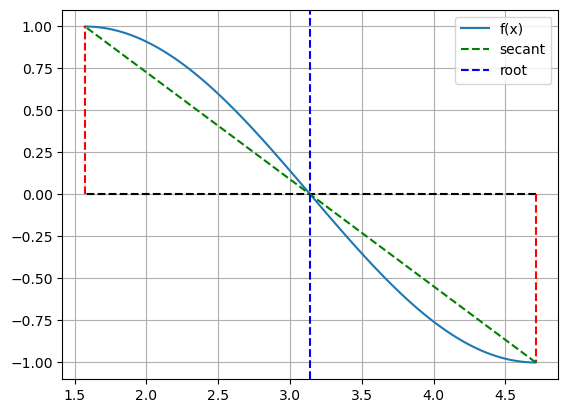

In [3]:
def f(x):
    return np.sin(x)

a = 3*np.pi/2
b = np.pi/2

xs = np.linspace(a, b, 100)

plt.plot(xs, f(xs), label='f(x)')
plt.plot([a, b], [0, 0], 'k--')
plt.plot([a, a], [0, f(a)], 'r--')
plt.plot([b, b], [0, f(b)], 'r--')
plt.plot([a, b], [f(a), f(b)], 'g--', label='secant')

plt.axvline(bisect(f, a, b), color='b', linestyle='--', label='root')

plt.grid()
plt.legend()

Example solving $ x^2 - 2 = 0$

In [4]:
print(f"Error = {abs(np.sqrt(2)-bisect(lambda x: x**2-2, 0, 10)):.11f}")

Within 1e-10: root= 1.4142135623842478 f(c)= 3.154454475406965e-11
Error = 0.00000000001


## Modelling an explosive epidemic

### The SIR model

The SIR model is one of the simplest compartmental models, and many models are derivatives of this basic form. The model consists of three compartments:

* S: The number of susceptible individuals. When a susceptible and an infectious individual come into "infectious contact", the susceptible individual contracts the disease and transitions to the infectious compartment.

* I: The number of infectious individuals. These are individuals who have been infected and are capable of infecting susceptible individuals.

* R: The number of removed (and immune) or deceased individuals. These are individuals who have been infected and have either recovered from the disease and entered the removed compartment, or died.

### Equations

$$\frac{dS}{dt} = -\frac{\beta S I}{N}$$

$$\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

### Parameters

* $\beta$ is the average number of contacts per person per time, multiplied by the probability of disease transmission in a contact between a susceptible and an infectious subject.

* $\gamma$ is the removal rate, i.e. the average number of recovered or deceased people per time.

### Example

Let's assume that $\beta = 0.2$ and $\gamma = 0.1$.

We can solve the equations using odeint or solve_ivp functions from scipy.integrate. The functions work slightly differently but are doing the same thing here. In the docs it says that [solve_ivp is the preferred method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#:~:text=For%20new%20code%2C%20use%20scipy.integrate.solve_ivp%20to%20solve%20a%20differential%20equation.).

In [5]:
beta = 0.2
gamma = 0.1

def dS(S, I):
    return -beta*S*I

def dI(S, I):
    return beta*S*I - gamma*I

def dR(I):
    return gamma*I

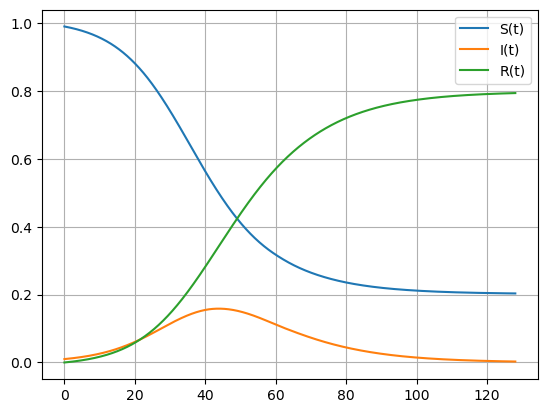

In [6]:
from scipy.integrate import solve_ivp

def SIR(t, y):
    S, I, R = y
    return [dS(S, I), dI(S, I), dR(I)]

y0 = [0.99, 0.01, 0]
t = np.linspace(0, 128, 1000)

sol = solve_ivp(SIR, [0, 128], y0, t_eval=t)

plt.figure()
plt.plot(sol.t, sol.y[0], label='S(t)')
plt.plot(sol.t, sol.y[1], label='I(t)')
plt.plot(sol.t, sol.y[2], label='R(t)')
plt.grid()
plt.legend()

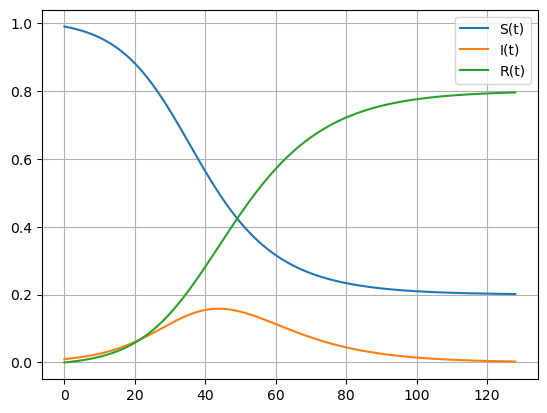

In [7]:
from scipy.integrate import odeint

def SIR(y, t):
    S, I, R = y
    return [dS(S, I), dI(S, I), dR(I)]

t = np.linspace(0, 128, 1000)

y0 = [0.99, 0.01, 0]

sol = odeint(SIR, y0, t)

plt.figure()
plt.plot(t, sol[:, 0], label='S(t)')
plt.plot(t, sol[:, 1], label='I(t)')
plt.plot(t, sol[:, 2], label='R(t)')
plt.grid()
plt.legend()


## Modelling students in the class room

### Variables

1. L = Number of learned students
2. U = Number of unlearned students
3. B = Number of bad students

### Parameters

1. $\alpha$ = Learning rate
2. $\beta$ = Unlearning rate
3. $\gamma$ = Bad student infection rate
4. $\delta$ = Bad student recovery rate

### Equations

$$\frac{dL}{dt} = \alpha U L - \gamma B L$$

$$\frac{dU}{dt} = -\alpha U L + \beta L - \gamma B U + \delta B $$

$$\frac{dB}{dt} = \gamma B U - \delta B $$

### Example

Let's assume that $\alpha = 0.1$, $\beta = 0.3$, $\gamma = 0.05$, and \delta = 0.05$.

Solve using rk4.

In [8]:
# Model

def dLdt(L, U, B, alpha, beta, gamma, delta):
    return alpha * U * L - beta * L

def dUdt(L, U, B, alpha, beta, gamma, delta):
    return - alpha * U * L + beta * L - gamma * B * U + delta * B

def dBdt(L, U, B, alpha, beta, gamma, delta):
    return gamma * B * U - delta * B
 
def dXdt(X, t, alpha, beta, gamma, delta):
    L, U, B = X
    return np.array([dLdt(L, U, B, alpha, beta, gamma, delta),
            dUdt(L, U, B, alpha, beta, gamma, delta),
            dBdt(L, U, B, alpha, beta, gamma, delta)])

In [9]:
# Initial conditions, domain, and parameters

X0 = np.array([10, 100, 10])
t = np.linspace(0, 1, 10000)
alpha = 0.1
beta = 0.3
gamma = 0.05
delta = 0.05

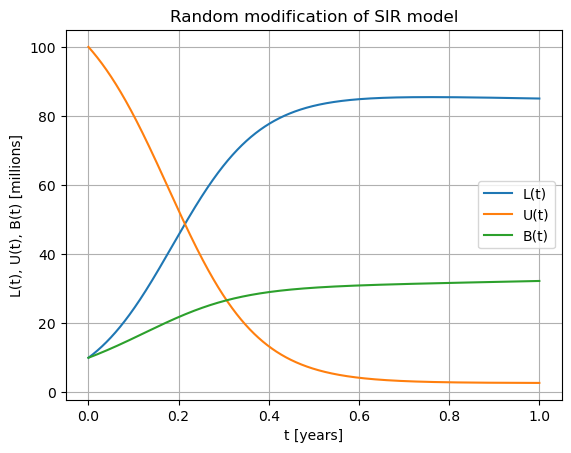

In [10]:
# Solve ODE with Fourth Order Runge-Kutta

def rk4(f, x0, t):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(len(t)-1):
        dt = t[i+1] - t[i]
        k1 = f(x[i], t[i])
        k2 = f(x[i] + k1 * dt / 2, t[i] + dt / 2)
        k3 = f(x[i] + k2 * dt / 2, t[i] + dt / 2)
        k4 = f(x[i] + k3 * dt, t[i] + dt)
        x[i+1] = x[i] + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
    return x

sol = rk4(lambda x, t: dXdt(x, t, alpha, beta, gamma, delta), X0, t)

plt.title("Random modification of SIR model")
plt.xlabel("t [years]")
plt.ylabel("L(t), U(t), B(t) [millions]")
plt.plot(t, sol[:, 0], label='L(t)')
plt.plot(t, sol[:, 1], label='U(t)')
plt.plot(t, sol[:, 2], label='B(t)')
plt.legend()
plt.grid()